In [1]:
# IMPORT FUNCTIONS
import pandas as pd
import pickle
import myokit.lib.plots as mp
from scipy.stats import spearmanr
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
import numpy as np
from important_functions import get_torord_phys_data, add_scalebar, new_parameter_convergence, get_sensitivities 
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.pyplot as plt
from math import log10
from important_functions import calc_APD, get_last_ap, run_model

##########################################################################################################################################################
# SET UP FIGURE PARAMETERS
plt.rcParams['font.size'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.constrained_layout.use'] = True

class ScalarFormatterClass(ScalarFormatter):
   def _set_format(self):
      self.format = "%1.2f"

yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))

##########################################################################################################################################################
# LOAD DATA

data_path = './data'
all_trials = pd.read_csv(data_path+'/all_data.csv.bz2')
fig2_data = pd.read_csv(data_path+'/fig2_data.csv.bz2')
cond_data = pickle.load(open(data_path+'/cond_data.pkl', 'rb'))
best_data = pd.read_csv(data_path+'/best_data.csv.bz2')
rrc_data = pd.read_csv(data_path+'/rrc_data.csv.bz2')
sens_data = pd.read_csv(data_path+'/sens_opt.csv.bz2')
sens_data_base = pd.read_csv(data_path+'/sens_baseline.csv.bz2')
sens_data_grandi = pd.read_csv(data_path+'/sens_grandi.csv.bz2')

data_path = './data/notes_data'
grandi_pop = pd.read_csv(data_path+'/grandi_pop.csv.bz2')
torord_pop = pd.read_csv(data_path+'/small_torord_pop.csv.bz2')

#data_path = '../new_ga_data/data/'
#all_trials_new = pd.read_csv(data_path+'all_trials.csv.bz2')

data_path = '../data/'
#all_trials_new = pd.read_csv(data_path+'all_data.csv.bz2')
all_trials_new = pd.read_csv(data_path+'trial3_info.csv.bz2')



In [4]:
from important_functions import get_ind_data, detect_abnormal_ap
import myokit

def rrc_search(ind, IC, max_rrc = 1, stim = 5.3, start = 0.2, length = 1, cl = 1000, path = './models/', model = 'tor_ord_endo2.mmt'):
    all_data = []
    #APs = list(range((10*cl)+int(start+length+4), (100*cl)+int(start+length+4), 5*cl)) #length needs to be an integer so it rounds if needed

    mod, proto = get_ind_data(ind, path, model) 
    proto.schedule(stim, start, length, cl, 0)
    proto.schedule(max_rrc, (5*cl)+int(start+length+4), cl-int(start+length+4), cl, 1)
    sim = myokit.Simulation(mod, proto)
    sim.set_state(IC)
    dat = sim.run(7*cl)

    d0 = get_last_ap(dat, 4, cl=cl)
    result_abnormal0 = detect_abnormal_ap(d0['t'], d0['v']) 
    all_data.append({**{'t_rrc': d0['t'], 'v_rrc': d0['v'], 'stim': 0}, **result_abnormal0})

    d3 = get_last_ap(dat, 5, cl=cl)
    result_abnormal3 = detect_abnormal_ap(d3['t'], d3['v'])
    all_data.append({**{'t_rrc': d3['t'], 'v_rrc': d3['v'], 'stim': max_rrc}, **result_abnormal3})

    #if result_EAD0 == 1 or result_RF0 == 1:
    if result_abnormal0['result'] == 1:
        RRC = 0

    #elif result_EAD3 == 0 and result_RF3 == 0:
    elif result_abnormal3['result'] == 0:
        # no abnormality at 0.3 stim, return RRC
        RRC = max_rrc

    else:
        low = 0
        high = max_rrc
        start_ap = 10
        while (high-low)>0.0025:
            mid = round((low + (high-low)/2), 4) 

            #mod, proto = get_ind_data(ind, path, model)  #added
            #proto.schedule(stim, start, length, cl, 0) #added
            sim.reset()
            sim.set_state(IC)
            proto.schedule(mid, (start_ap*cl)+int(start+length+4), cl-int(start+length+4), cl, 1)
            #sim = myokit.Simulation(mod, proto)
            sim.set_protocol(proto)
            dat = sim.run((start_ap+2)*cl) #added

            data = get_last_ap(dat, start_ap, cl=cl)
            result_abnormal = detect_abnormal_ap(data['t'], data['v'])
            all_data.append({**{'t_rrc': data['t'], 'v_rrc': data['v'], 'stim': mid}, **result_abnormal})
            
            start_ap = start_ap+5
            if result_abnormal['result'] == 0:
                # no RA so go from mid to high
                low = mid

            else:
                #repolarization failure so go from mid to low 
                high = mid

        
        for i in list(range(1, len(all_data))):
            if all_data[-i]['result'] == 0:
                RRC = all_data[-i]['stim']
                break
            else:
                RRC = 0 #in this case there would be no stim without an RA

    result = {'RRC':RRC, 'data':all_data}

    return(result)

In [5]:
dat, IC = run_model(None, 1)
result = rrc_search(None, IC, max_rrc = 1)

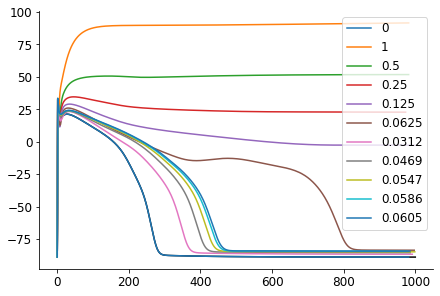

In [6]:
plt.plot(dat['engine.time'], dat['membrane.v'], color = 'black')
for i in range(0, len(result['data'])):
    plt.plot(result['data'][i]['t_rrc'], result['data'][i]['v_rrc'], label = result['data'][i]['stim'])

plt.legend()

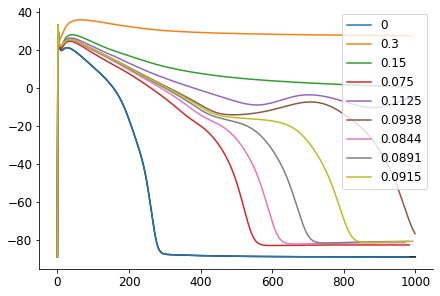

In [14]:
plt.plot(dat['engine.time'], dat['membrane.v'], color = 'black')
for i in range(0, len(result['data'])):
    plt.plot(result['data'][i]['t_rrc'], result['data'][i]['v_rrc'], label = result['data'][i]['stim'])

plt.legend()

# **Notes**<br>This notebook keeps record of extra analysis that did not make it into the manuscript.

#### Steady State Conditions in a small population of Tor-ORd models 

There seems to be a different prepacing value among various papers in the field:
- **Tomek 2019** prepaced for 130 beats at 1 Hz and then ran 20 more beats simulated at different conditions. "150 beats in total for the control condition is a compromise between total runtime and similarity to the stable-state behavior". 
- **Cummings 2013** paced each model under "baseline conditions until the APD varied by less than +/- 1% for 1000 consecutive beats. The first beat in this window was considered the minimum number of beats the model must be paced for all simulations, and was determined separately at fast (2 Hz) and slow (0.2 Hz) pacing." 
- **Ballouz 2020** "All models were paced at 1 Hz with a stimulus of -40mV and duration of 1ms and allowed to equilibrate for 300 beats. We then analysed the next four beats (to allow for the possibility of development of alternans) after the equilibration stage." This was done to develop a population of models and so even though each model is different and could have a different time to steady state, the same amount of beats were used to prepace.

To test things I ran 5 APs after no prepacing and then evaluated after every 100 beats up to 1000. Below you could see that there is great variability in APD90 between the 5 AP beats with no prepacing. After 100 beats of prepacing, the average variability between the 5 action potentials reduces to under 1ms.

In [2]:
# Steady State Function
def collect_steady_state_data(pop, paces = list(range(100, 1100, 100))):

    data = []

    for i in range(0, len(pop)):
        ind_data = {}
        ind = pop.iloc[i].to_dict()
        dat, IC = run_model([ind], 5, prepace = 0)
        all_apds = []
        for ap in range(0, 5):
            ap_data = get_last_ap(dat, ap)
            all_apds.append(calc_APD(ap_data['t'], ap_data['v'], 90))

        # Store Initial Data for each individual
        ind_data['prepace_0'] = 0
        ind_data['t_0'] = dat['engine.time'].tolist()
        ind_data['v_0'] = dat['membrane.v'].tolist()
        ind_data['apds_0'] = all_apds

        for p in paces:
            dat, IC = run_model([ind], 5, prepace = p, I0=IC)
            all_apds = []
            for ap in range(0, 5):
                ap_data = get_last_ap(dat, ap)
                all_apds.append(calc_APD(ap_data['t'], ap_data['v'], 90))

            # Store all data for each individual
            ind_data['prepace_'+str(p)] = p
            ind_data['t_'+str(p)] = dat['engine.time'].tolist()
            ind_data['v_'+str(p)] = dat['membrane.v'].tolist()
            ind_data['apds_'+str(p)] = all_apds
        
        data.append({**ind, **ind_data})

    data = pd.DataFrame(data)
    data.to_csv('./data/small_torord_pop.csv')

# If you need to recollect population data uncomment the lines of code below (this takes about 25 minutes to run!)
#pop_10 = all_trials[(all_trials['gen']==0)&(all_trials['total_feature_error']==0)&(all_trials['total_morph_error']==0)].reset_index(drop=True)[0:10].filter(like = 'multiplier')
#collect_steady_state_data(pop_10)


Text(0, 0.5, 'Average AP Variation')

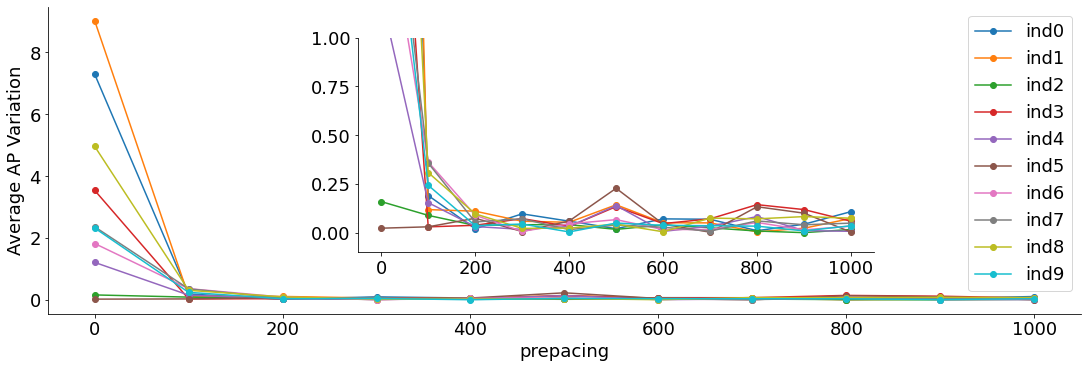

In [3]:
fig, axs = plt.subplots(1, figsize = (15, 5), constrained_layout = True)
axs_in = axs.inset_axes([0.3, 0.2, 0.5, 0.7]) 
for i in list(range(0, len(torord_pop))):
    axs.plot(list(range(0, 1100, 100)), [abs(np.mean(np.diff(eval(a)))) for a in torord_pop.filter(like = 'apd').iloc[i].tolist()], marker = 'o', label = 'ind'+str(i))
    axs_in.plot(list(range(0, 1100, 100)), [abs(np.mean(np.diff(eval(a)))) for a in torord_pop.filter(like = 'apd').iloc[i].tolist()], marker = 'o', label = 'ind'+str(i))

axs_in.set_ylim([-0.1, 1])
axs.legend(bbox_to_anchor=(1,1))
axs.set_xlabel('prepacing')
axs.set_ylabel('Average AP Variation')
    

Text(0.5, 1.0, 'Each color represents a given individual.\nMultiple points for each color represent the 1 of 5 action potentials for each pace.')

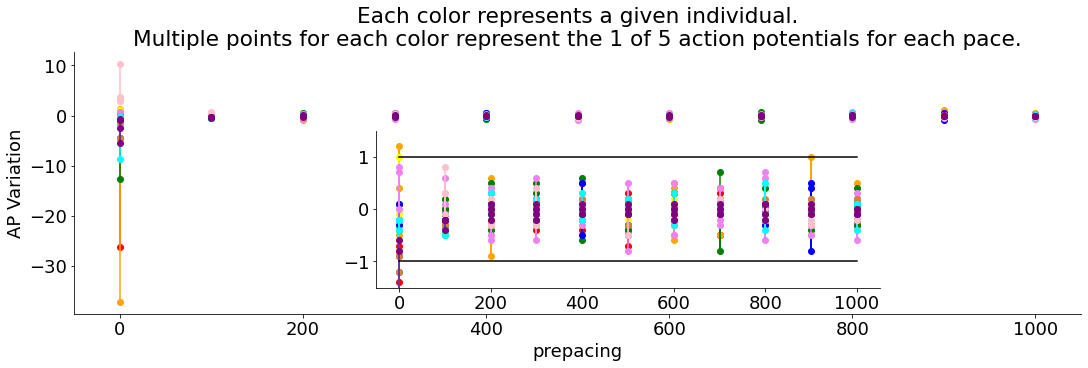

In [4]:
fig, axs = plt.subplots(1, figsize = (15, 5), constrained_layout = True)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet', 'peru', 'cyan', 'pink', 'purple']
axs_in = axs.inset_axes([0.3, 0.1, 0.5, 0.6]) 
for i in list(range(0, len(torord_pop))):
    ind_data = torord_pop.filter(like = 'apd').iloc[i].tolist()
    for j in range(0, len(ind_data)):
        y_data = [round(ap, 1) for ap in np.diff(eval(ind_data[j]))]
        axs.plot([j*100]*len(y_data), y_data, marker = 'o', label = 'ind'+str(i), color = colors[i])
        axs_in.plot([j*100]*len(y_data), y_data, marker = 'o', label = 'ind'+str(i), color = colors[i])

axs_in.set_ylim([-1.5, 1.5])
axs_in.plot(range(0, 1100, 100), [1]*11, color = 'black')
axs_in.plot(range(0, 1100, 100), [-1]*11, color = 'black')
#axs.legend(bbox_to_anchor=(1,1))
axs.set_xlabel('prepacing')
axs.set_ylabel('AP Variation')
axs.set_title('Each color represents a given individual.\nMultiple points for each color represent the 1 of 5 action potentials for each pace.')

KeyError: 'trial'

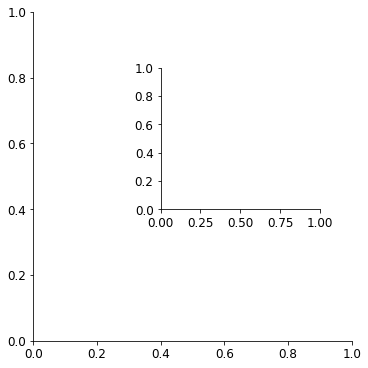

In [3]:
fig, axs4 = plt.subplots(1, figsize = (5,5), constrained_layout = True)


axs4_in = axs4.inset_axes([0.4, 0.4, 0.5, 0.43])

for i in list(range(0, max(all_trials_new['trial']))):

    d = all_trials_new[all_trials_new['trial']==i]
    bsts = []
    avgs = []

    for g in list(range(0, max(d['gen']))):
        d_gen = d[d['gen']==g]['fitness'].to_list()
        bsts.append(min(d_gen))
        avgs.append(np.mean(d_gen))

    axs4.scatter(list(range(0, max(d['gen']))), bsts, color = 'cadetblue', s=5)
    axs4.scatter(list(range(0, max(d['gen']))), avgs, color = 'black', s=5)
    axs4_in.scatter(list(range(0, max(d['gen']))), bsts, color = 'cadetblue', s=5)
    axs4_in.scatter(list(range(0, max(d['gen']))), avgs, color = 'black', s=5)

axs4.set_ylabel('Cost')
axs4.set_xlabel('Generation');
#axs4.indicate_inset_zoom(axs4_in, edgecolor="black", alpha = 1)
axs4_in.set_ylim([13000, 20000])
axs4_in.legend(['Best', 'Mean'], loc='upper right', bbox_to_anchor = (1.2,1.5), frameon = False, fontsize = 8)
axs4_in.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

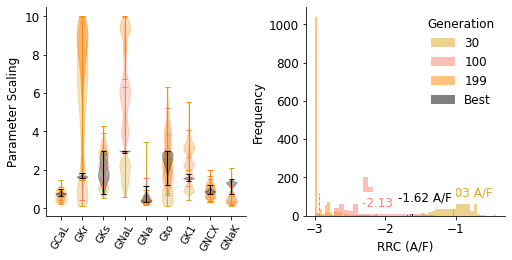

In [45]:
# MAKE PLOT
fig, axs1 = plt.subplots(1, 2, figsize = (7,3.5), constrained_layout = True)
gens = [30, 100, 199]
labels = [str(gen) for gen in gens]
colors = ['goldenrod', 'salmon','darkorange']

for g in range(0, len(gens)):
    #data = all_trials_new[(all_trials_new['gen']==gens[g])].sort_values(by=['fitness']).reset_index().iloc[0:400]
    data = all_trials_new[(all_trials_new['gen']==gens[g])]
    violin = axs1[0].violinplot(data.filter(like = 'multiplier'))
    axs1[1].hist(-data['rrc']*10, color = colors[g], bins = 25, label = labels[g], alpha = 0.5)
    mean_rrc = np.mean(-data['rrc']*10)
    axs1[1].plot([mean_rrc, mean_rrc], [0, 120], color = colors[g], linestyle = 'dashed', linewidth= 1)
    if g == 0:
        height = 100
    else:
        height = 50
    axs1[1].annotate(str(round(mean_rrc,2))+' A/F', ((mean_rrc)-0.2,height), bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="white", lw=2), color = colors[g])
    
    for vp in violin['bodies']:
        vp.set_facecolor(colors[g])
        vp.set_edgecolor(colors[g])

    for partname in ('cbars','cmins','cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor(colors[g])
        vp.set_linewidth(1)


#data = all_trials_old[(all_trials_old['gen']==99)].sort_values(by=['fitness']).reset_index().iloc[0:100]
#data = pd.read_csv('./data/best_data.csv.bz2')
violin = axs1[0].violinplot(best_data.filter(like = 'multiplier'))
axs1[1].hist(-best_data['rrc'].iloc[0:80]*10, color = 'black', bins = 10, alpha = 0.5, label = 'Best')
mean_rrc = np.mean(-best_data['rrc']*10)
axs1[1].plot([mean_rrc, mean_rrc], [0, 90], color = 'black', linestyle = 'dashed', linewidth= 1)
axs1[1].annotate(str(round(mean_rrc,2))+' A/F', ((mean_rrc)-0.2,75), bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="white", lw=2), color = 'black')

for vp in violin['bodies']:
    vp.set_facecolor('black')
    vp.set_edgecolor('black')

for partname in ('cbars','cmins','cmaxes'):
    vp = violin[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)

axs1[0].set_ylabel('Parameter Scaling', fontsize = 12)
axs1[0].set_xticks(list(range(1, 10)))
axs1[0].set_xticklabels(['GCaL', 'GKr', 'GKs', 'GNaL', 'GNa', 'Gto', 'GK1', 'GNCX', 'GNaK'], rotation = 60, fontsize = 10);

axs1[1].set_ylabel('Frequency', fontsize=12)
axs1[1].set_xlabel('RRC (A/F)', fontsize = 12)
axs1[1].legend(bbox_to_anchor = (1,1), frameon=False, title = 'Generation', fontsize = 12)

#plt.savefig('./figures/figR3.pdf', trasparent=True)
#plt.savefig('./figures/figR3.png', trasparent=True)

C:\Users\Kristin\AppData\Local\Temp/ipykernel_27684/2161702373.py:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figures/figR3.pdf', trasparent=True)
C:\Users\Kristin\AppData\Local\Temp/ipykernel_27684/2161702373.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('./figures/figR3.png', trasparent=True)


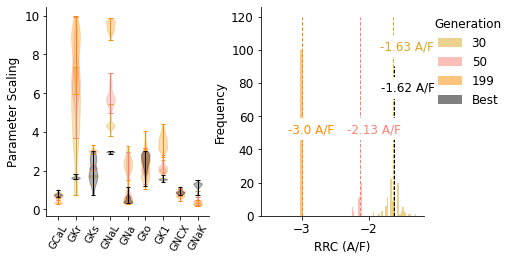

In [7]:
# MAKE PLOT
fig, axs1 = plt.subplots(1, 2, figsize = (7,3.5), constrained_layout = True)
gens = [30, 50, 199]
labels = [str(gen) for gen in gens]
colors = ['goldenrod', 'salmon','darkorange']

for g in range(0, len(gens)):
    data = all_trials_new[(all_trials_new['gen']==gens[g])].sort_values(by=['fitness']).reset_index().iloc[0:100]
    #data = all_trials[(all_trials['gen']==gens[g])]
    violin = axs1[0].violinplot(data.filter(like = 'multiplier'))
    axs1[1].hist(-data['rrc']*10, color = colors[g], bins = 25, label = labels[g], alpha = 0.5)
    mean_rrc = np.mean(-data['rrc']*10)
    axs1[1].plot([mean_rrc, mean_rrc], [0, 120], color = colors[g], linestyle = 'dashed', linewidth= 1)
    if g == 0:
        height = 100
    else:
        height = 50
    axs1[1].annotate(str(round(mean_rrc,2))+' A/F', ((mean_rrc)-0.2,height), bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="white", lw=2), color = colors[g])
    
    for vp in violin['bodies']:
        vp.set_facecolor(colors[g])
        vp.set_edgecolor(colors[g])

    for partname in ('cbars','cmins','cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor(colors[g])
        vp.set_linewidth(1)


#data = all_trials_old[(all_trials_old['gen']==99)].sort_values(by=['fitness']).reset_index().iloc[0:100]
#data = pd.read_csv('./data/best_data.csv.bz2')
violin = axs1[0].violinplot(best_data.filter(like = 'multiplier'))
axs1[1].hist(-best_data['rrc'].iloc[0:80]*10, color = 'black', bins = 25, alpha = 0.5, label = 'Best')
mean_rrc = np.mean(-best_data['rrc']*10)
axs1[1].plot([mean_rrc, mean_rrc], [0, 90], color = 'black', linestyle = 'dashed', linewidth= 1)
axs1[1].annotate(str(round(mean_rrc,2))+' A/F', ((mean_rrc)-0.2,75), bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="white", lw=2), color = 'black')

for vp in violin['bodies']:
    vp.set_facecolor('black')
    vp.set_edgecolor('black')

for partname in ('cbars','cmins','cmaxes'):
    vp = violin[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)

axs1[0].set_ylabel('Parameter Scaling', fontsize = 12)
axs1[0].set_xticks(list(range(1, 10)))
axs1[0].set_xticklabels(['GCaL', 'GKr', 'GKs', 'GNaL', 'GNa', 'Gto', 'GK1', 'GNCX', 'GNaK'], rotation = 60, fontsize = 10);

axs1[1].set_ylabel('Frequency', fontsize=12)
axs1[1].set_xlabel('RRC (A/F)', fontsize = 12)
axs1[1].legend(bbox_to_anchor = (1,1), frameon=False, title = 'Generation', fontsize = 12)

plt.savefig('./figures/figR3.pdf', trasparent=True)
plt.savefig('./figures/figR3.png', trasparent=True)

total_morph_error=1271741.3475829961
total_feature_error=117373.66740137692
rrc_error=4506.82375


C:\Users\Kristin\AppData\Local\Temp/ipykernel_27684/1206284052.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/figR1.pdf', trasparent=True)
C:\Users\Kristin\AppData\Local\Temp/ipykernel_27684/1206284052.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/figR1.png', trasparent=True)


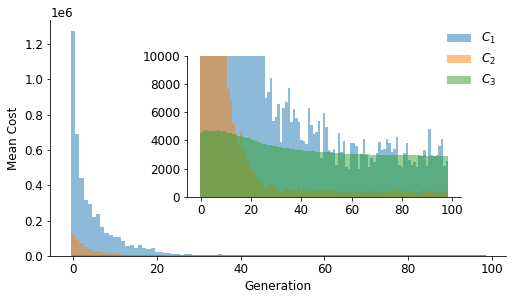

In [10]:
fig, axs = plt.subplots(1, figsize = (7,4), constrained_layout = True)
axs_in = axs.inset_axes([0.3, 0.25, 0.6, 0.6]) 

def find_mode(np_array):
    vals, counts = np.unique(np_array, return_counts=True)
    index = np.argmax(counts)
    return(vals[index])

costs = ['total_morph_error', 'total_feature_error', 'rrc_error']
labels = ['$C_1$', '$C_2$', '$C_3$']

for i in range(0, len(costs)):
    cost = costs[i]
    all_cs = []
    for g in range(0, 99):
        c = np.mean(all_trials[all_trials['gen']==g][cost].tolist())
        if g == 0:
            print(cost+'='+str(c))
        #c = find_mode(np.array(all_trials[all_trials['gen']==g][cost]))
        all_cs.append(c)

    axs.bar(range(0, len(all_cs)), all_cs, 1, alpha = 0.5, label = labels[i])
    axs_in.bar(range(0, len(all_cs)), all_cs, 1, alpha = 0.5)

axs_in.set_ylim([0, 10000])
axs.set_ylabel('Mean Cost')
axs.set_xlabel('Generation')
axs.legend(frameon=False)

plt.savefig('figures/figR1.pdf', trasparent=True)
plt.savefig('figures/figR1.png', trasparent=True)

C:\Users\Kristin\AppData\Local\Temp/ipykernel_27684/1828923282.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/figR2.pdf', trasparent=True)
C:\Users\Kristin\AppData\Local\Temp/ipykernel_27684/1828923282.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/figR2.png', trasparent=True)


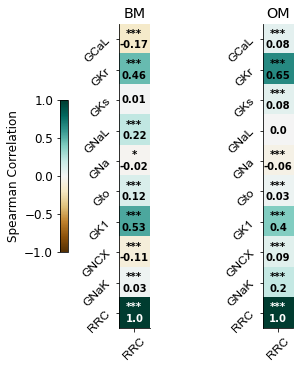

In [11]:
fig, axs1 = plt.subplots(1, 2, figsize = (5,5), constrained_layout = True)

from scipy.stats import spearmanr

stat = spearmanr
color_map = 'BrBG'
cond_labels = ['GCaL', 'GKr', 'GKs', 'GNaL', 'GNa', 'Gto', 'GK1', 'GNCX', 'GNaK', 'RRC']
cond_labels_x = ['RRC']
gens = [15, 85]
titles = ['BM', 'OM']

for g in range(0, len(gens)):
    if g == 0:
        # 19125 inds
        data = all_trials[(all_trials['gen']<gens[g])][['i_cal_pca_multiplier', 'i_kr_multiplier', 'i_ks_multiplier', 'i_nal_multiplier', 'i_na_multiplier', 'i_to_multiplier', 'i_k1_multiplier', 'i_NCX_multiplier', 'i_nak_multiplier', 'rrc']]
        #data = all_trials[(all_trials['gen']<gens[g]) & (all_trials['total_morph_error']==0) & (all_trials['total_feature_error']==0)][['i_cal_pca_multiplier', 'i_kr_multiplier', 'i_ks_multiplier', 'i_nal_multiplier', 'i_na_multiplier', 'i_to_multiplier', 'i_k1_multiplier', 'i_NCX_multiplier', 'i_nak_multiplier', 'rrc']]
    else:
        #50307 inds
        data = all_trials[(all_trials['gen']>gens[g])][['i_cal_pca_multiplier', 'i_kr_multiplier', 'i_ks_multiplier', 'i_nal_multiplier', 'i_na_multiplier', 'i_to_multiplier', 'i_k1_multiplier', 'i_NCX_multiplier', 'i_nak_multiplier', 'rrc']]
        #data = all_trials[(all_trials['gen']>gens[g]) & (all_trials['total_morph_error']==0) & (all_trials['total_feature_error']==0)][['i_cal_pca_multiplier', 'i_kr_multiplier', 'i_ks_multiplier', 'i_nal_multiplier', 'i_na_multiplier', 'i_to_multiplier', 'i_k1_multiplier', 'i_NCX_multiplier', 'i_nak_multiplier', 'rrc']]

    corr = data.corr(method = 'spearman')
    pval = data.corr(method=lambda x, y: stat(x, y)[1]) - np.eye(*corr.shape)

    #drop columns you dont want show in matrix
    corr.drop(labels=['i_cal_pca_multiplier', 'i_kr_multiplier', 'i_ks_multiplier', 'i_nal_multiplier', 'i_na_multiplier', 'i_to_multiplier', 'i_k1_multiplier', 'i_NCX_multiplier', 'i_nak_multiplier'], axis=1, inplace=True)
    pval.drop(labels=['i_cal_pca_multiplier', 'i_kr_multiplier', 'i_ks_multiplier', 'i_nal_multiplier', 'i_na_multiplier', 'i_to_multiplier', 'i_k1_multiplier', 'i_NCX_multiplier', 'i_nak_multiplier'], axis=1, inplace=True)

    im = axs1[g].imshow(corr, cmap = color_map, vmin=-1, vmax=1)
    axs1[g].set_xticks(np.arange(len(cond_labels_x)))
    axs1[g].set_xticklabels(cond_labels_x, rotation = 45, fontname="Arial");
    axs1[g].set_yticks(np.arange(len(cond_labels)))
    axs1[g].set_yticklabels(cond_labels, rotation = 45, fontname="Arial");
    axs1[g].set_title(titles[g])

    texts = []
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            t = str(round(corr.iloc[i,j], 2))
            pv = pval.iloc[i,j]
            p = ''
            c = 'black'
            if pv < 0.05: 
                p = '*\n'
            if pv < 0.01: 
                p = '**\n'
            if pv < 0.001: 
                p = '***\n'
            if corr.iloc[i,j]>0.8 or corr.iloc[i,j]<-0.8:
                c = 'white'
            text = im.axes.text(j, i, p+t, color = c, ha="center", va="center", fontsize=10, fontweight="bold")
            texts.append(text)

cbar = axs1[0].figure.colorbar(im, ax=axs1, shrink = 0.5, location = 'left')
cbar.ax.set_ylabel('Spearman Correlation', rotation=90, va="bottom")

plt.savefig('figures/figR2.pdf', trasparent=True)
plt.savefig('figures/figR2.png', trasparent=True)

#### Pair-wise relationships between profile ion-channel conductances.
Each point represents an individual from the population of 220 best, or those with a fitness lower than 2800 (n = 220), and is colored by total cost ($C_1+C_2+C_3$). The log base 10 of each conductance is plotted on the x and y axes.

C:\Users\Kristin\AppData\Local\Temp/ipykernel_11636/956134199.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[c1, c2].set_xticklabels([-0.5, '', 0.5], fontsize=11)
C:\Users\Kristin\AppData\Local\Temp/ipykernel_11636/956134199.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[c1, c2].set_yticklabels([-0.5, 0.0, 0.5], fontsize=11)


Text(0, 0.5, 'Cost')

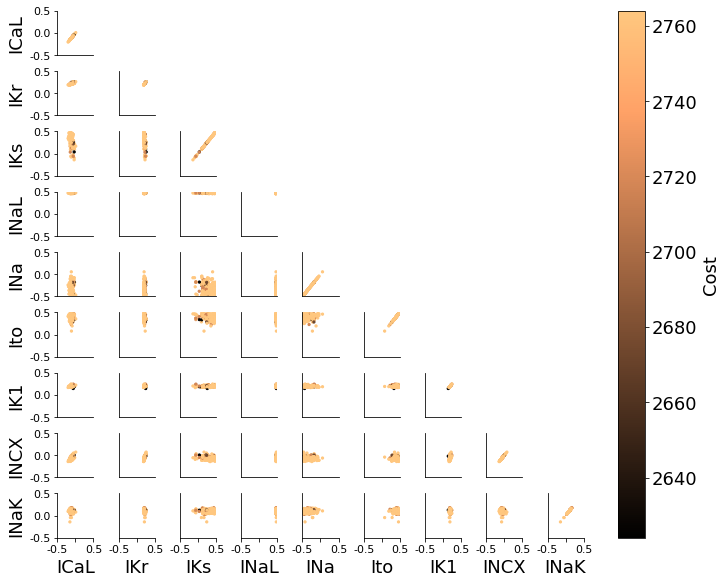

In [5]:
# SET UP FIGURE
fig, axs = plt.subplots(9,9, figsize = (10,8), constrained_layout = True)

######################################################################################
# PAIRWISE SCATTER PLOTS
low_rrc_data = all_trials[(all_trials['rrc_error']<2800) & (all_trials['total_morph_error']==0) & (all_trials['total_feature_error']==0)].filter(['fitness', 'i_cal_pca_multiplier', 'i_kr_multiplier', 'i_ks_multiplier', 'i_nal_multiplier', 'i_na_multiplier', 'i_to_multiplier', 'i_k1_multiplier', 'i_NCX_multiplier', 'i_nak_multiplier'])
low_rrc_data = low_rrc_data.reset_index()

conds = low_rrc_data.filter(like='multiplier').columns.tolist()
labs = ['ICaL', 'IKr', 'IKs', 'INaL', 'INa', 'Ito', 'IK1', 'INCX', 'INaK']
for c1 in list(range(0, len(conds))):
    for c2 in list(range(0, len(conds))):
        im = axs[c1, c2].scatter(np.log10(np.array(low_rrc_data[conds[c2]])), np.log10(np.array(low_rrc_data[conds[c1]])), c=low_rrc_data.fitness, cmap='copper', s=5)
        axs[c1, c2].set_xlim([-0.5, 0.5])
        axs[c1, c2].set_ylim([-0.5, 0.5])
        #axs[c1, c2].set_xticks([-0.5, 0.5])
        axs[c1, c2].set_xticklabels([-0.5, '', 0.5], fontsize=11)
        axs[c1, c2].set_yticklabels([-0.5, 0.0, 0.5], fontsize=11)

        if c1 == 8:
            axs[c1, c2].set_xlabel(labs[c2])
        else: 
            axs[c1, c2].xaxis.set_visible(False) # Hide only x axis
        
        if c2 == 0:
            axs[c1, c2].set_ylabel(labs[c1])
        else:
            axs[c1, c2].yaxis.set_visible(False) # Hide only y axis
        
        if c2 > c1:
            fig.delaxes(axs[c1, c2])

cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('Cost', rotation=90)

######################################################################################
# SAVE FIGURE
#plt.savefig(figures_path+'figS3.pdf', trasparent=True)
#plt.savefig(figures_path+'figS3.png', trasparent=True, dpi = 300)

#### Global RRC Sensitivity Analysis for the Grandi model

The sensitivity analysis in D is the global multiparameter analysis which matches pretty closely to the local sensitivity analysis that was done for the manuscript. 

Text(0, 0.5, ' RRC\nSensitivity')

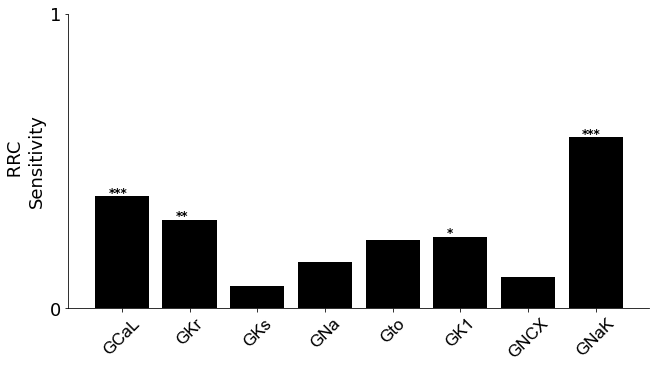

In [6]:
# SET UP FIGURE
fig, axs = plt.subplots(1, figsize = (9, 5), constrained_layout = True)
cond_labels_g = ['GCaL', 'GKr', 'GKs', 'GNa', 'Gto', 'GK1', 'GNCX', 'GNaK']
lines = ['solid', 'dotted', 'dashdot', 'dashed']
labs = ['GBM1', 'GBM2', 'GBM3', 'GBM4']
print_labs = ['GB-N', 'GB-', 'GB-$I_{CaL}$', 'GB-$I_{NaL}$']

######################################################################################
# C) MULTIPARAMETER SENSTIVITY ANALYSIS
errors = ['rrc_error']
labels = ['RRC Fitness']
sensitivities, pvalues = get_sensitivities(grandi_pop, errors[0])
axs.bar(list(range(0, len(sensitivities))), sensitivities, color = 'black')
axs.set_xticks(list(range(0, len(sensitivities))))
axs.set_xticklabels(cond_labels_g, rotation = 45, fontname="Arial", fontsize = 17);
axs.set_yticks([0, 1])

for i in list(range(0, len(sensitivities))):
    label = ''
    if pvalues[i] < 0.05: 
        label = '*'
    if pvalues[i] < 0.01: 
        label = '**'
    if pvalues[i] < 0.001: 
        label = '***'
    axs.text(i-0.2,sensitivities[i], label, fontsize = 12, fontweight ='bold', color ='black')   

axs.set_ylabel(' RRC\nSensitivity')

    

##########################################################################################################

#### GA Progression and Global Analyses for the ToR-ORd model

A is a multiparameter progression analysis and B is a global sensitvity analysis using generation 0 of all GA trials and the KS statistic. 

A progression analysis was completed to assess the sensitivity of the genetic algorithm optimization to each ion-channel conductance. To complete this analysis, the best 100 individuals from all GA trials was separated from the initial population and updated per generation. The 100 groups of 100 best individuals were then used to calculate the variance in each parameter per generation. Slower convergence indicates a less sensitive parameter. IKr and ICaL converge the fastest compared to the other ion channels, which is consistent with prior results: $C_1$ and $C_3$ are most sensitive to ICaL and IKr, respectively. This figure also suggests that INaL is important later in optimization (or for the optimized model) as it appears to have the fastest relative convergence after generation 30.

A global multi-parameter RRC sensitivity analysis was performed for the GB model as previously described (Groenendaal et al.). RRC sensitivities to ion-channel conductances were determined using the initial GA population of 200 individuals for each of the 8 trials. The best 10% of the individuals with the lowest error, and the remaining 90% of the individuals were separated into two groups and compared using a two-sided Kolmogorov-Smirnov test. The statistic of a two-sided Kolmogorov-Smirnov test was used as the metric of RRC sensitivity. Since it uses generation 0, this analysis is really measuring the sensitivity on a population of tor-ord models rather than evaluating the optimized model. Ultimately, this analysis was not used because it is not clear weather the KS statistic could be used on discontinuous functions or not. 

Text(-0.1, 1.05, 'B')

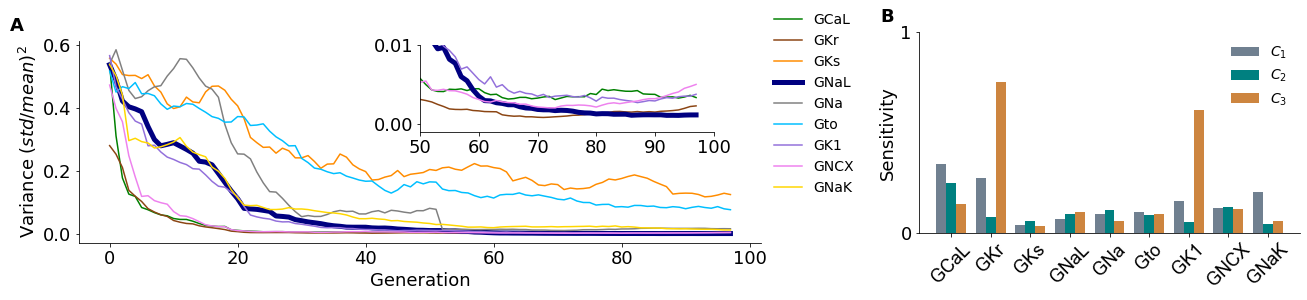

In [7]:
# SET UP FIGURE
fig = plt.figure(figsize = (18, 4)) 
gs = GridSpec(nrows=1, ncols=2, figure = fig, width_ratios=[2, 1]) #height_ratios=[2, 1], width_ratios=[2, 1]

sub0 = fig.add_subfigure(gs[0, 0])
axs0 = sub0.subplots()

sub2 = fig.add_subfigure(gs[0, 1])
axs2= sub2.subplots()


##########################################################################
# B) PROGRESSION ANALYSIS
axs0_in = axs0.inset_axes([0.5, 0.55, 0.43, 0.43]) 
df_dicts_average = new_parameter_convergence(all_trials);
conds = df_dicts_average.filter(like='multiplier').columns.tolist();
cond_labels = ['GCaL', 'GKr', 'GKs', 'GNaL', 'GNa', 'Gto', 'GK1', 'GNCX', 'GNaK']
#cond_colors = ['tan', 'saddlebrown', 'powderblue', 'navy', 'royalblue', 'orange', 'peru', 'gold', 'slategrey']
cond_colors = ['green', 'saddlebrown', 'darkorange', 'navy', 'gray', 'deepskyblue', 'mediumpurple', 'violet', 'gold']

for c in list(range(0, len(conds))):
    if cond_labels[c] == 'GNaL':
        w = 5
    else:
        w = 1.5

    axs0.plot(df_dicts_average['generation'], df_dicts_average[conds[c]].tolist(), label = cond_labels[c], color = cond_colors[c], linewidth = w);
    axs0_in.plot(df_dicts_average['generation'], df_dicts_average[conds[c]].tolist(), label = cond_labels[c], color = cond_colors[c], linewidth = w);
axs0.set_ylabel('Variance $(std/mean)^2$')
axs0.set_xlabel('Generation')
axs0_in.set_xlim([50,100])
axs0_in.set_ylim([-0.001, 0.01])
#axs0.indicate_inset_zoom(axs0_in, edgecolor="black", alpha = 1)
#axs0.add_patch(Rectangle((50, -0.01), 45, 0.04, edgecolor = 'black', fill=False, lw=3, zorder=5)) #add rectangle
axs0.legend(bbox_to_anchor = (1,1.2), frameon=False, fontsize = 14) #loc = (0, 1.1), ncol = 5

##########################################################################################################
# C) Multiparameter sensitivity analysis
errors = ['total_morph_error', 'total_feature_error',  'rrc_error']
labels = ['$C_1$', '$C_2$', '$C_3$']
cond_colors = ['slategrey', 'teal', 'peru']
x = np.arange(len(cond_labels))

for lab in list(range(0, len(labels))):
    sensitivities, pvalues = get_sensitivities(all_trials, errors[lab])
    if lab == 0:
        axs2.bar(x-0.25, sensitivities, color = cond_colors[lab], label = labels[lab], width = 0.25)
    if lab == 1:
        axs2.bar(x, sensitivities, color = cond_colors[lab], label = labels[lab], width = 0.25)
    if lab == 2:
        axs2.bar(x+0.25, sensitivities, color = cond_colors[lab], label = labels[lab], width = 0.25)
    axs2.set_xticks(list(range(0, len(sensitivities))))
    axs2.set_xticklabels(cond_labels, rotation = 45, fontname="Arial");

    axs2.set_yticks([0, 1]) 
    axs2.set_ylabel('Sensitivity') 

axs2.legend(fontsize = 14, frameon=False)

##########################################################################################################################################################
# LETTER LABELS
axs0.text(-0.1, 1.05, 'A', transform=axs0.transAxes, weight='bold')
axs2.text(-0.1, 1.05, 'B', transform=axs2.transAxes, weight='bold')
##########################################################################################################################################################

#### Local Sensitivity Analysis for the Optimized ToR-ORd model
This is additional data for the local sensitivity analaysis that was used in the paper.

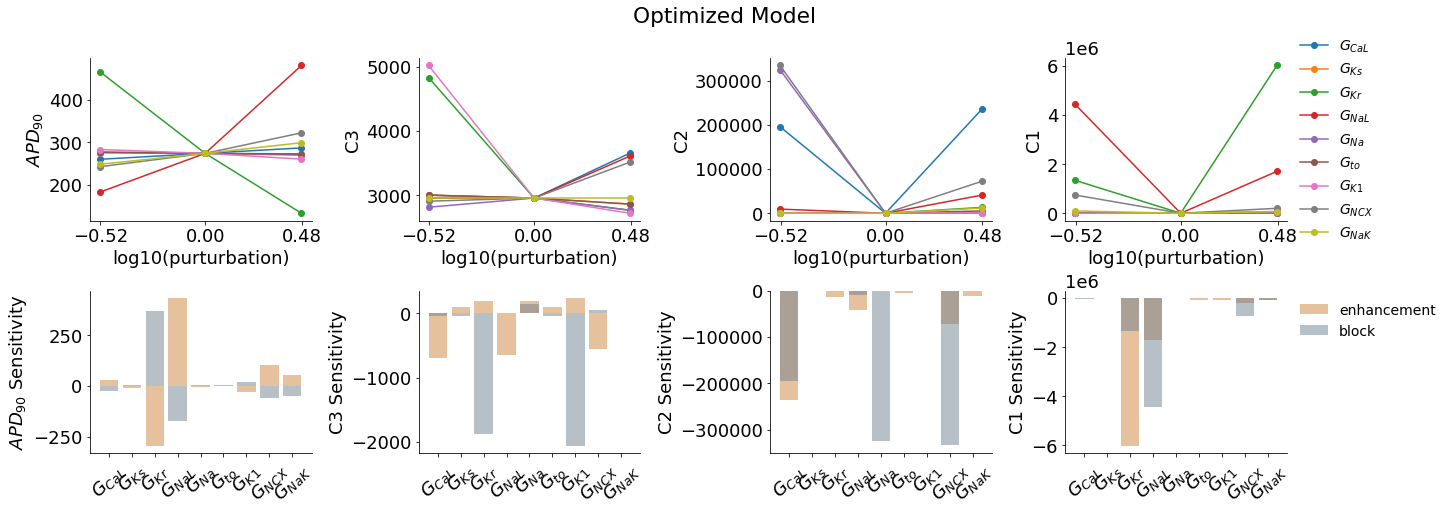

In [8]:
conductance_labels = ['$G_{CaL}$', '$G_{Ks}$', '$G_{Kr}$', '$G_{NaL}$', '$G_{Na}$', '$G_{to}$', '$G_{K1}$', '$G_{NCX}$', '$G_{NaK}$']

data_type = ['apd', 'rrc_error', 'feature_error', 'morph_error'] 
labels = ['$APD_{90}$', 'C3', 'C2', 'C1'] 
x_axis = [0.3, 1, 1.5, 2, 2.5, 3]

fig, axs = plt.subplots(2, len(data_type), figsize = (20,7), constrained_layout = True)
for d in list(range(0, len(data_type))):
    sensitivities = sens_data.filter([data_type[d]+'_'+str(pur) for pur in x_axis])
    enhance_sensitivities = []
    block_sensitivities = []

    for i in list(range(0, len(sensitivities[sensitivities.columns[0]]))):
        y_axis = sensitivities.loc[i].to_list()
        if data_type[d]=='apd':
            y_axis = [np.mean(eval(l)) for l in y_axis]

            # use slope as a measure of sensitivity for apd90
            block_sensitivities.append(-(y_axis[1]-y_axis[0])/(log10(x_axis[1])-log10(x_axis[0])))
            enhance_sensitivities.append((y_axis[1]-y_axis[5])/(log10(x_axis[1])-log10(x_axis[5])))

        else:
            # Use change in  C1, C2, and C3 metrics as measure of sensitivity for features, morphology, and RRC, respecitively. 
            block_sensitivities.append(y_axis[1]-y_axis[0])
            enhance_sensitivities.append(y_axis[1]-y_axis[5])
            #block_sensitivities.append(np.abs((y_axis[1]-y_axis[0])/(x_axis[1]-x_axis[0])))
            #enhance_sensitivities.append(np.abs((y_axis[1]-y_axis[5])/(x_axis[1]-x_axis[5])))

        axs[0, d].plot([log10(x_axis[0]), log10(x_axis[1]), log10(x_axis[5])], [y_axis[0], y_axis[1], y_axis[5]], marker = 'o', label = conductance_labels[i])

    axs[0, d].set_xlabel('log10(purturbation)')
    axs[0, d].set_ylabel(labels[d])
    axs[0, d].set_xticks([round(log10(0.3),2), round(log10(1),2), round(log10(3),2)])
    axs[1, d].bar(list(range(0,9)), enhance_sensitivities, color = 'peru', alpha = 0.5, label = 'enhancement')
    axs[1, d].bar(list(range(0,9)), block_sensitivities, color = 'slategrey', alpha = 0.5, label = 'block')
    axs[1, d].set_xticks(list(range(0, 9)))
    axs[1, d].set_xticklabels(conductance_labels, rotation = 45, fontname="Arial")
    axs[1, d].set_ylabel(labels[d]+' Sensitivity')

fig.suptitle('Optimized Model')
axs[0,3].legend(bbox_to_anchor=(1,1.2), frameon = False, fontsize = 14)
axs[1,3].legend(bbox_to_anchor=(1,1), frameon = False, fontsize = 14)

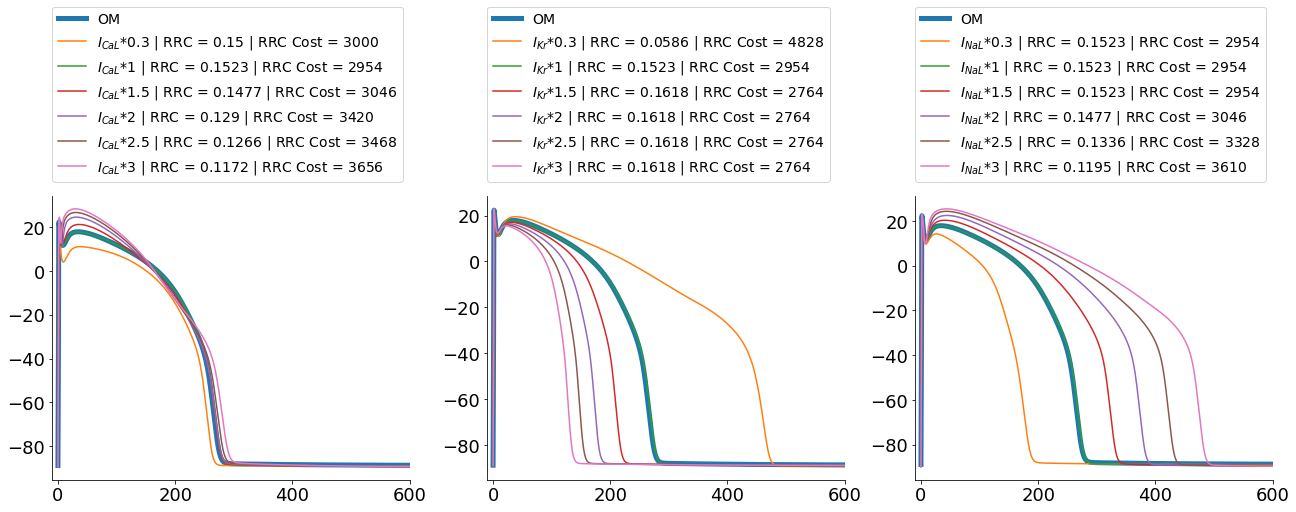

In [4]:
from important_functions import get_last_ap
#vals = ['initial', '0.3', '1', '1.5', '2', '2.5', '3']
vals = ['0.3', '1', '1.5', '2', '2.5', '3']
conds = ['i_cal_pca_multiplier', 'i_kr_multiplier', 'i_nal_multiplier']
lab = ['$I_{CaL}$*', '$I_{Kr}$*', '$I_{NaL}$*']
fig, axs = plt.subplots(1, len(conds), figsize = (18,7), constrained_layout = True)

for i in list(range(0,len(conds))):
    axs[i].plot(eval(best_data['t'][0]), eval(best_data['v'][0]), label = 'OM', linewidth=5)
    for val in vals:
        t = eval(sens_data[sens_data['cond'] == conds[i]]['t_'+val].reset_index(drop = True)[0])
        v = eval(sens_data[sens_data['cond'] == conds[i]]['v_'+val].reset_index(drop = True)[0])
        data = get_last_ap([t, v], 4, cl = 1000, type = 'half')
        rrc_val = str(sens_data[sens_data['cond'] == conds[i]]['rrc'+val].reset_index(drop=True)[0])
        rrc_cost = str(sens_data[sens_data['cond'] == conds[i]]['rrc_error_'+val].reset_index(drop=True)[0])
        axs[i].plot(data['t']-data['t'][0], data['v'], label = lab[i]+val+' | RRC = '+rrc_val+' | RRC Cost = '+rrc_cost)
    axs[i].legend(fontsize = 14, loc = (0, 1.05))
    axs[i].set_xlim([-10, 600])

#### Local Sensitivity Analysis for the Baseline ToR-ORd model

In [10]:
# Run if you need to change column names
sens_data_base = sens_data_base.rename(columns={'rrc0.3':'rrc_0.3', 'rrc1':'rrc_1', 'rrc1.5':'rrc_1.5', 'rrc2':'rrc_2', 'rrc2.5':'rrc_2.5', 'rrc3':'rrc_3'})

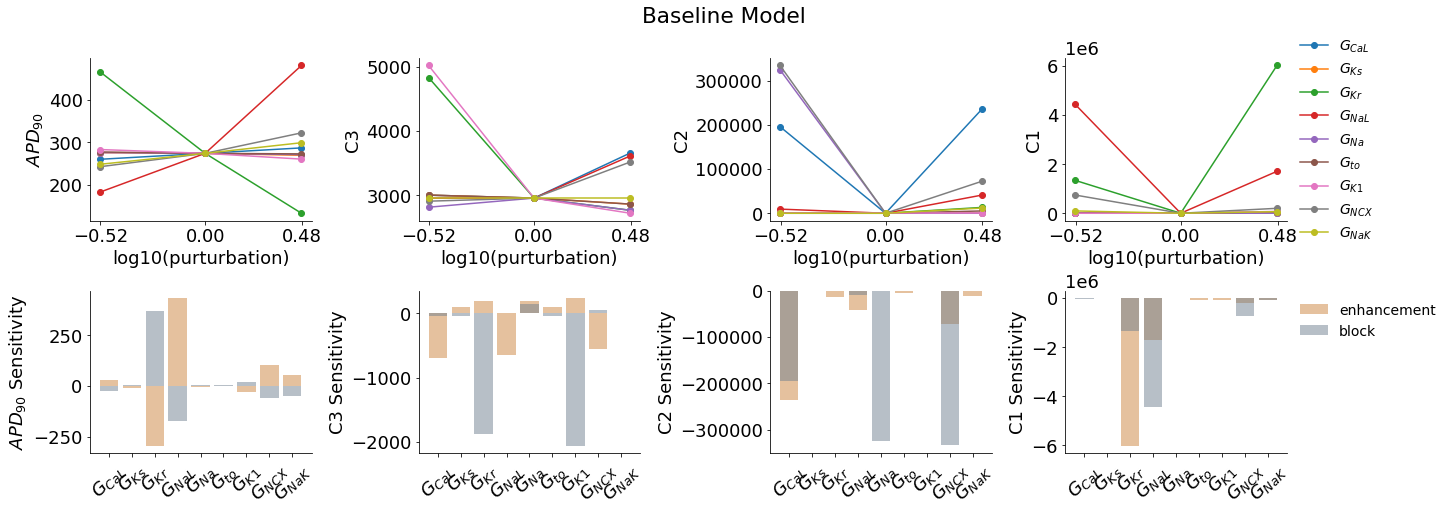

In [11]:
conductance_labels = ['$G_{CaL}$', '$G_{Ks}$', '$G_{Kr}$', '$G_{NaL}$', '$G_{Na}$', '$G_{to}$', '$G_{K1}$', '$G_{NCX}$', '$G_{NaK}$']

data_type = ['apd', 'rrc_error', 'feature_error', 'morph_error'] 
labels = ['$APD_{90}$', 'C3', 'C2', 'C1'] 
x_axis = [0.3, 1, 1.5, 2, 2.5, 3]

fig, axs = plt.subplots(2, len(data_type), figsize = (20,7), constrained_layout = True)
for d in list(range(0, len(data_type))):
    sensitivities = sens_data_base.filter([data_type[d]+'_'+str(pur) for pur in x_axis])
    enhance_sensitivities = []
    block_sensitivities = []

    for i in list(range(0, len(sensitivities[sensitivities.columns[0]]))):
        y_axis = sensitivities.loc[i].to_list()
        
        if data_type[d]=='apd':
            y_axis = [np.mean(eval(l)) for l in y_axis]

            # use slope as a measure of sensitivity for apd90
            block_sensitivities.append(-(y_axis[1]-y_axis[0])/(log10(x_axis[1])-log10(x_axis[0])))
            enhance_sensitivities.append((y_axis[1]-y_axis[5])/(log10(x_axis[1])-log10(x_axis[5])))

        else:
            # Use change in  C1, C2, and C3 metrics as measure of sensitivity for features, morphology, and RRC, respecitively. 
            block_sensitivities.append(y_axis[1]-y_axis[0])
            enhance_sensitivities.append(y_axis[1]-y_axis[5])
            #block_sensitivities.append(np.abs((y_axis[1]-y_axis[0])/(x_axis[1]-x_axis[0])))
            #enhance_sensitivities.append(np.abs((y_axis[1]-y_axis[5])/(x_axis[1]-x_axis[5])))

        axs[0, d].plot([log10(x_axis[0]), log10(x_axis[1]), log10(x_axis[5])], [y_axis[0], y_axis[1], y_axis[5]], marker = 'o', label = conductance_labels[i])

    axs[0, d].set_xlabel('log10(purturbation)')
    axs[0, d].set_ylabel(labels[d])
    axs[0, d].set_xticks([round(log10(0.3),2), round(log10(1),2), round(log10(3),2)])
    axs[1, d].bar(list(range(0,9)), enhance_sensitivities, color = 'peru', alpha = 0.5, label = 'enhancement')
    axs[1, d].bar(list(range(0,9)), block_sensitivities, color = 'slategrey', alpha = 0.5, label = 'block')
    axs[1, d].set_xticks(list(range(0, 9)))
    axs[1, d].set_xticklabels(conductance_labels, rotation = 45, fontname="Arial")
    axs[1, d].set_ylabel(labels[d]+' Sensitivity')

fig.suptitle('Baseline Model')
axs[0,3].legend(bbox_to_anchor=(1,1.2), frameon = False, fontsize = 14)
axs[1,3].legend(bbox_to_anchor=(1,1), frameon = False, fontsize = 14)

## Local Sensitivity Analysis for the Grandi Model

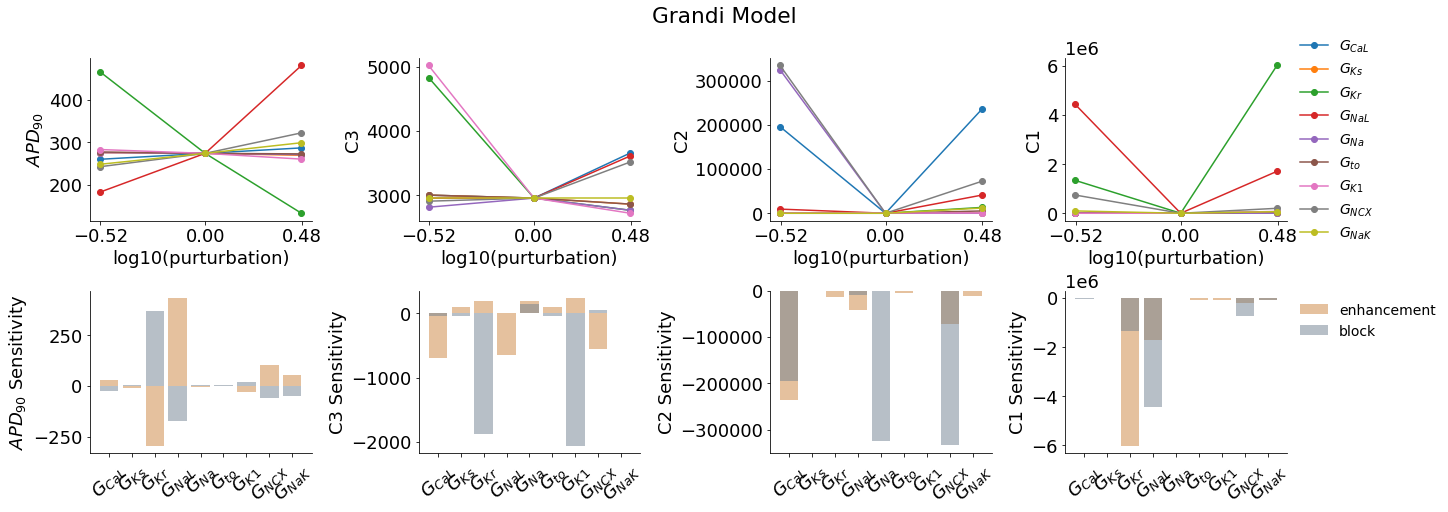

In [12]:
conductance_labels = ['$G_{CaL}$', '$G_{Ks}$', '$G_{Kr}$', '$G_{NaL}$', '$G_{Na}$', '$G_{to}$', '$G_{K1}$', '$G_{NCX}$', '$G_{NaK}$']

data_type = ['apd', 'rrc_error', 'feature_error', 'morph_error'] 
labels = ['$APD_{90}$', 'C3', 'C2', 'C1'] 
x_axis = [0.3, 1, 1.5, 2, 2.5, 3]

fig, axs = plt.subplots(2, len(data_type), figsize = (20,7), constrained_layout = True)
for d in list(range(0, len(data_type))):
    sensitivities = sens_data_grandi.filter([data_type[d]+'_'+str(pur) for pur in x_axis])
    enhance_sensitivities = []
    block_sensitivities = []

    for i in list(range(0, len(sensitivities[sensitivities.columns[0]]))):
        y_axis = sensitivities.loc[i].to_list()
        if data_type[d]=='apd':
            y_axis = [np.mean(eval(l)) for l in y_axis]

            # use slope as a measure of sensitivity for apd90
            block_sensitivities.append(-(y_axis[1]-y_axis[0])/(log10(x_axis[1])-log10(x_axis[0])))
            enhance_sensitivities.append((y_axis[1]-y_axis[5])/(log10(x_axis[1])-log10(x_axis[5])))

        else:
            # Use change in  C1, C2, and C3 metrics as measure of sensitivity for features, morphology, and RRC, respecitively. 
            block_sensitivities.append(y_axis[1]-y_axis[0])
            enhance_sensitivities.append(y_axis[1]-y_axis[5])
            #block_sensitivities.append(np.abs((y_axis[1]-y_axis[0])/(x_axis[1]-x_axis[0])))
            #enhance_sensitivities.append(np.abs((y_axis[1]-y_axis[5])/(x_axis[1]-x_axis[5])))

        axs[0, d].plot([log10(x_axis[0]), log10(x_axis[1]), log10(x_axis[5])], [y_axis[0], y_axis[1], y_axis[5]], marker = 'o', label = conductance_labels[i])

    axs[0, d].set_xlabel('log10(purturbation)')
    axs[0, d].set_ylabel(labels[d])
    axs[0, d].set_xticks([round(log10(0.3),2), round(log10(1),2), round(log10(3),2)])
    axs[1, d].bar(list(range(0,9)), enhance_sensitivities, color = 'peru', alpha = 0.5, label = 'enhancement')
    axs[1, d].bar(list(range(0,9)), block_sensitivities, color = 'slategrey', alpha = 0.5, label = 'block')
    axs[1, d].set_xticks(list(range(0, 9)))
    axs[1, d].set_xticklabels(conductance_labels, rotation = 45, fontname="Arial")
    axs[1, d].set_ylabel(labels[d]+' Sensitivity')

fig.suptitle('Grandi Model')
axs[0,3].legend(bbox_to_anchor=(1,1.2), frameon = False, fontsize = 14)
axs[1,3].legend(bbox_to_anchor=(1,1), frameon = False, fontsize = 14)

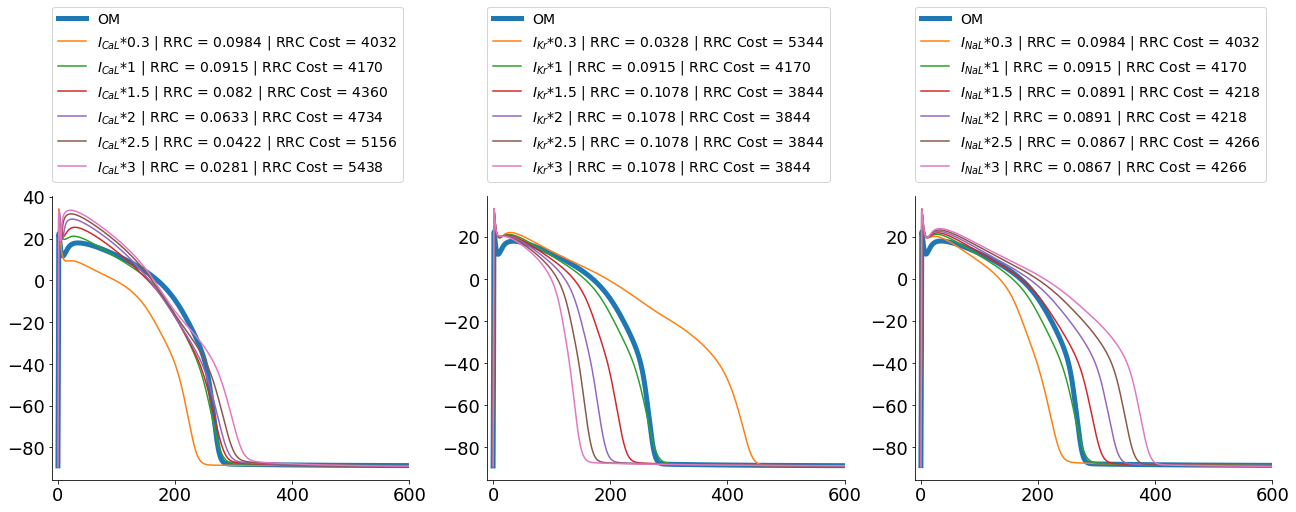

In [9]:
#vals = ['initial', '0.3', '1', '1.5', '2', '2.5', '3']
vals = ['0.3', '1', '1.5', '2', '2.5', '3']
conds = ['i_cal_pca_multiplier', 'i_kr_multiplier', 'i_nal_multiplier']
lab = ['$I_{CaL}$*', '$I_{Kr}$*', '$I_{NaL}$*']
fig, axs = plt.subplots(1, len(conds), figsize = (18,7), constrained_layout = True)

for i in list(range(0,len(conds))):
    axs[i].plot(eval(best_data['t'][0]), eval(best_data['v'][0]), label = 'OM', linewidth=5)
    for val in vals:
        t = eval(sens_data_base[sens_data_base['cond'] == conds[i]]['t_'+val].reset_index(drop = True)[0])
        v = eval(sens_data_base[sens_data_base['cond'] == conds[i]]['v_'+val].reset_index(drop = True)[0])
        data = get_last_ap([t, v], 4, cl = 1000, type = 'half')
        rrc_val = str(sens_data_base[sens_data_base['cond'] == conds[i]]['rrc'+val].reset_index(drop=True)[0])
        rrc_cost = str(sens_data_base[sens_data_base['cond'] == conds[i]]['rrc_error_'+val].reset_index(drop=True)[0])
        axs[i].plot(data['t']-data['t'][0], data['v'], label = lab[i]+val+' | RRC = '+rrc_val+' | RRC Cost = '+rrc_cost)
    axs[i].legend(fontsize = 14, loc = (0, 1.05))
    axs[i].set_xlim([-10, 600])